In [95]:
import os
import pandas as pd
import numpy as np
import random
import logging

pd.set_option('display.max_columns', None)

In [13]:
logging.basicConfig(filename='household_data_mismatches.log', level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

In [138]:
def process_census_data(df):
    """
    Process the census data to create a lookup for working probabilities based on gender and prefecture.

    Parameters:
    - df: DataFrame containing the census data.

    Returns:
    - A dictionary with (gender, prefecture) tuples as keys and working probabilities as values.
    """
    df['pref'] = df['地域名'].str.split("-").str[0].str[:2]
    df['gender'] = df['男女'].str.split("_").str[0]
    return df.set_index(['gender', 'pref'])['労働力率'].to_dict()

def transform_pref_code(city_code):
    """
    Transform the city code to a prefecture code.

    Parameters:
    - city_code: The city code as an integer.

    Returns:
    - The prefecture code as a string.
    """
    city_code_str = str(city_code)
    return city_code_str[:2] if len(city_code_str) == 5 else '0'+city_code_str[0]

def get_occupation(age, gender, prefecture, working_probability_lookup):
    """
    Determine the working status based on age, gender, and prefecture.

    Parameters:
    - age: Age of the individual.
    - gender: Gender of the individual.
    - prefecture: Prefecture code of the individual's location.
    - working_probability_lookup: A dictionary for looking up working probabilities.

    Returns:
    - An occupation code.
    """
    if age <= 4:
        return 10
    elif age <= 6:
        return 11
    elif age <= 12:
        return 12
    elif age <= 15:
        return 13
    elif age <= 18:
        return 14
    elif age <= 64:
        key = (str(int(gender)), str(prefecture))
        working_probability = working_probability_lookup.get(key, 0.5) / 100.0
        if working_probability == 0.5:
            print(key)
        return np.random.choice([21, 23], p=[working_probability, 1 - working_probability])
    else:
        return 23

def create_individual(base_info, age, gender, pref_code, person_counter, working_probability_lookup):
    """
    Create an individual's information based on the given parameters.

    Parameters:
    - base_info: A dictionary containing the base information shared by all individuals in the household.
    - age: Age of the individual.
    - gender: Gender of the individual.
    - pref_code: Prefecture code of the individual's location.
    - person_counter: A counter for assigning a unique person_id within the household.
    - working_probability_lookup: A dictionary for looking up working probabilities.

    Returns:
    - A dictionary with the individual's information.
    """
    individual = base_info.copy()
    individual['person_id'] = f'{person_counter}'
    age = age + random.randint(0, 4)
    individual['age'] = age
    individual['gender'] = gender
    individual['occupation'] = get_occupation(age, gender, pref_code, working_probability_lookup)
    
    return individual

def generate_individuals(household_data, city_code, working_probability_lookup):
    """
    Generate individual records from household data.

    Parameters:
    - household_data: DataFrame containing household data.
    - city_code: City code for the household location.
    - working_probability_lookup: A dictionary for looking up working probabilities.

    Returns:
    - A DataFrame with individual records.
    """
    individuals = []
    global person_counter

    for _, row in household_data.iterrows():
        base_info = {
            'household_id': f'{city_code}_{int(row["gid"])}',
            'family_type': row['family_group_code'],
            'city_code': row['city_code'],
            'lon': row['lon'],
            'lat': row['lat'],
        }
        pref_code = transform_pref_code(city_code)

        # Process householder, spouse, parents, children, and others
        for role in ['hh', 'spouse', 'parent_male', 'parent_female']:
            age_col = f'age_code_{role}'
            gender_col = f'gender_code_{role}'

            if pd.notna(row[age_col]) and pd.notna(row[gender_col]):
                individual = create_individual(base_info, row[age_col], row[gender_col], pref_code, person_counter, working_probability_lookup)
                individuals.append(individual)
                person_counter += 1

        # Process children and other members if applicable
        for member_type, col_step in [('child', 4), ('others', 5)]:
            start_index = household_data.columns.get_loc(f"gender_code_1st_{member_type}")
            end_index = household_data.columns.get_loc(f"{member_type}_counts_15th_grandchild") if member_type == 'child' else household_data.columns.get_loc(f"generation_flag_15th_{member_type}")

            for i in range(start_index, end_index, col_step):
                if i + 2 >= len(household_data.columns):  # Ensure we don't go beyond the DataFrame's columns
                    break

                gender, age = row.iloc[i], row.iloc[i + 1]
                if pd.notna(gender) and pd.notna(age):
                    individual = create_individual(base_info, age, gender, pref_code, person_counter, working_probability_lookup)
                    individuals.append(individual)
                    person_counter += 1

        # Check if the number of generated individuals matches the expected number
        if person_counter - 1 != int(row['n_household_member']):
            logging.warning(f"Mismatch in household {row['gid']} in city {city_code}: Expected {row['n_household_member']}, got {person_counter - 1}")

    return pd.DataFrame(individuals)

In [ ]:
household_path = '/mnt/large/data/household_estimation_data_2020/世帯推計データ(加工済み)_202401/sisetu_plus_all/'
pseudo_pop_path = '/mnt/large/data/PseudoPFLOW/ver2.0/Population/'

# Load census data for working probabilities
census_data_path = '/mnt/large/data/PseudoPFLOW/Processing/2020NationalCensusLabor.csv'
census_data = pd.read_csv(census_data_path)
working_probability_lookup = process_census_data(census_data)

dtype_conversion = {
    'household_id': 'str',
    'family_type': 'Int64',
    'city_code': 'Int64',
    'age': 'Int64', 
    'gender': 'Int64'
}

person_counter = 1

for subdir, dirs, files in os.walk(household_path):
    dirs.sort()  # Sort directories in-place
    files.sort()  # Sort files in-place
    
    pref_folder = os.path.basename(subdir)

    pseudo_dir_path = os.path.join(pseudo_pop_path, pref_folder)

    # Check if the directory exists, if not, create it
    if not os.path.exists(pseudo_dir_path):
        os.makedirs(pseudo_dir_path)
        print(f"Created directory: {pseudo_dir_path}")

    for file in files:
        # Construct the full file path
        print(file, person_counter)
        city_code = file.split('_')[0]
        household_data_path = os.path.join(subdir, file)
        household_data = pd.read_csv(household_data_path)
        
        # Generate individual records
        try:
            individuals_df = generate_individuals(household_data, city_code, working_probability_lookup)
            individuals_df = individuals_df.astype(dtype_conversion)
            individuals_df.to_csv(pseudo_dir_path + '/person_' + city_code + '.csv', index=False)
        except KeyError as e:
            print(f"Error: {e}. This column name does not exist in individuals_df DataFrame for file {file}.")

01101_household_estimation_data_2020.csv 1
01102_household_estimation_data_2020.csv 241894
01103_household_estimation_data_2020.csv 526434
01104_household_estimation_data_2020.csv 785980
01105_household_estimation_data_2020.csv 992848
01106_household_estimation_data_2020.csv 1214296
01107_household_estimation_data_2020.csv 1345370
01108_household_estimation_data_2020.csv 1558564
01109_household_estimation_data_2020.csv 1680559
01110_household_estimation_data_2020.csv 1819373
01202_household_estimation_data_2020.csv 1928001
01203_household_estimation_data_2020.csv 2171736
01204_household_estimation_data_2020.csv 2279482
01205_household_estimation_data_2020.csv 2598753
01206_household_estimation_data_2020.csv 2678775
01207_household_estimation_data_2020.csv 2839783
01208_household_estimation_data_2020.csv 3002174
01209_household_estimation_data_2020.csv 3115501
01210_household_estimation_data_2020.csv 3122461
01211_household_estimation_data_2020.csv 3198803
01212_household_estimation_dat

## check 

In [122]:
df = pd.read_csv('/mnt/large/data/PseudoPFLOW/ver2.0/Population/13/person_13101.csv')
df

,household_id,family_type,city_code,lon,lat,person_id,age,gender,occupation
0,13101_1,2,13101,139.742721,35.683014,33560036,31,2,21
1,13101_1,2,13101,139.742721,35.683014,33560037,31,1,23
2,13101_1,2,13101,139.742721,35.683014,33560038,4,2,10
3,13101_2,16,13101,139.742721,35.683014,33560039,48,2,23
4,13101_3,16,13101,139.742721,35.683014,33560040,59,1,23
...,...,...,...,...,...,...,...,...,...
65493,13101_36650,2,13101,139.775059,35.700081,33625529,55,1,23
65494,13101_36650,2,13101,139.775059,35.700081,33625530,49,2,21
65495,13101_36651,16,13101,139.775192,35.700396,33625531,32,1,23
65496,13101_36652,4,13101,139.778753,35.697077,33625532,48,2,21


<Axes: >

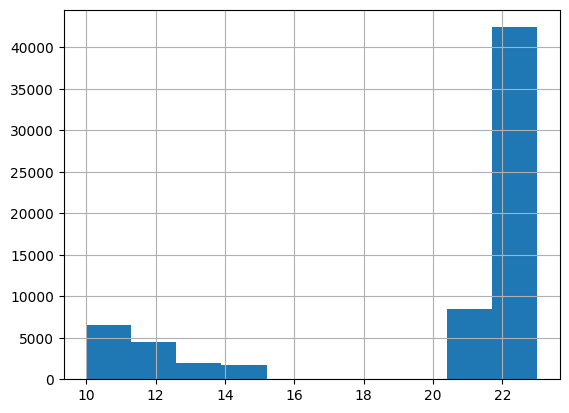

In [123]:
df['occupation'].hist()

In [125]:
df = pd.read_csv('/mnt/large/data/PseudoPFLOW/agent/23/person_23101.csv', header=None)
df

,0,1,2,3,4,5,6,7,8
0,23101_1,16,23101,136.934883,35.173305,69852418,85,1,23
1,23101_2,16,23101,136.936138,35.173211,69852419,23,2,21
2,23101_3,16,23101,136.936138,35.173211,69852420,29,2,21
3,23101_4,16,23101,136.934956,35.173726,69852421,43,2,21
4,23101_5,16,23101,136.935470,35.175077,69852422,73,1,23
...,...,...,...,...,...,...,...,...,...
162632,23101_84909,2,23101,136.990533,35.164792,70015050,35,2,23
162633,23101_84909,2,23101,136.990533,35.164792,70015051,6,2,12
162634,23101_84910,16,23101,136.990204,35.164981,70015052,41,2,21
162635,23101_84911,1,23101,136.990422,35.164874,70015053,75,1,23


<Axes: >

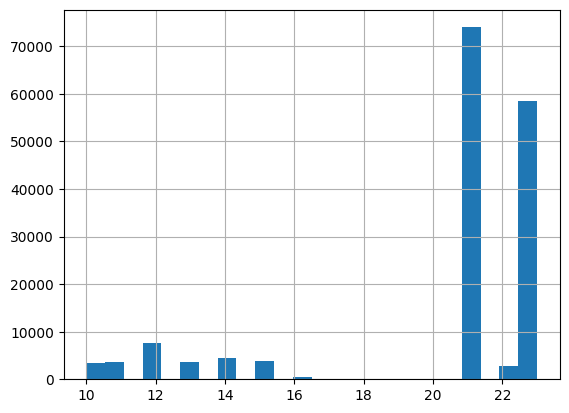

In [127]:
df.iloc[:, 8].hist(bins=24)

In [128]:
df.iloc[:, 8].value_counts()

8
21    73993
23    58521
12     7523
14     4425
15     3920
13     3726
11     3614
10     3464
22     2895
16      556
Name: count, dtype: int64

In [135]:
df = pd.read_csv('/mnt/large/data/PseudoPFLOW/Activity/23/activity_23101.csv', names=['pid', 'age', 'gender', 'occupation', 'starttime', 'duration', 'activity', 'lon', 'lat', 'code'])
df

,pid,age,gender,occupation,starttime,duration,activity,lon,lat,code
0,69852419,23,2,21,0,24300,1,136.936138,35.173211,23101
1,69852419,23,2,21,24300,43200,500,136.939615,35.189383,23101
2,69852419,23,2,21,67500,18900,1,136.936138,35.173211,23101
3,69852420,29,2,21,0,24300,1,136.936138,35.173211,23101
4,69852420,29,2,21,24300,27900,2,136.931653,35.169472,23101
...,...,...,...,...,...,...,...,...,...,...
508767,70015047,13,2,13,55800,30600,1,136.990217,35.164552,23101
508768,70015051,6,2,12,0,22500,1,136.990533,35.164792,23101
508769,70015051,6,2,12,22500,1800,3,136.988622,35.163481,23101
508770,70015051,6,2,12,24300,36000,3,136.988622,35.163481,23101


In [136]:
len(df.groupby('pid'))

156278

<Axes: >

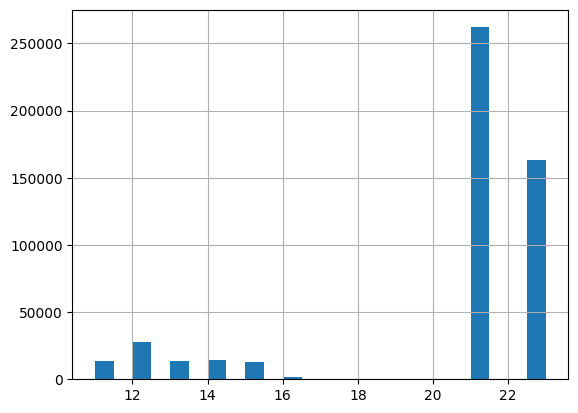

In [133]:
df.iloc[:, 3].hist(bins=24)

In [137]:
df.iloc[:, 3].value_counts()

occupation
21    261953
23    162932
12     27940
14     14417
13     13775
11     13276
15     12674
16      1805
Name: count, dtype: int64